# Assignment 5: Classical Control
Name: Mads Yar

Purdue Username: myar


In this assignment, you will implement and tune a trajectory following controller for a 2-degree of freedom(DoF) robotic arm.

## Getting Started

We'll be using OpenAI gym, along with PyBullet, to model the robot's environment.
- [OpenAI gym](https://gym.openai.com/) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.
- [PyBullet](https://pybullet.org/wordpress/) is an open-source physics engine that we'll use to model the robot.
- [pybullet-gym](https://github.com/benelot/pybullet-gym) is an open-source library that implements a variety of gym environments using PyBullet as the backend. One of these environments is `ReacherPyBulletEnv-v0`, the robotic arm that you'll be working with.

## Installation Instructions
Before running this notebook, you'll need to install `gym` and `pybullet-gym`, like so:
```bash
~ # install gym
~ pip install gym
~ # install pybullet-gym
~ git clone https://github.com/benelot/pybullet-gym.git
~ cd pybullet-gym
~ pip install -e .
```

## Overview: 2-DOF robotic arm

In [1]:
# load libraries (if this fails, see "Installation Instructions")
import gym
import numpy as np
import pybulletgym.envs
import matplotlib.pyplot as plt
import pybullet


pybullet build time: Nov 25 2025 23:14:51


In [2]:
# initialize the environment

# This try-except is to make sure there is only a single pybullet connection set-up
try:
    env.reset()
except NameError:
    env = gym.make("ReacherPyBulletEnv-v0")

env.render(mode="human")
obs = env.reset()

/Users/madsyar/Desktop/Kandidat/3. semester/pybullet-gym/pybulletgym/envs/roboschool/envs/env_bases.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/Users/madsyar/Desktop/Kandidat/3. semester/gym25-env/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


argv[0]=
Version = 4.1 Metal - 88.1
Vendor = Apple
Renderer = Apple M3 Pro
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


In [3]:
pybullet.resetDebugVisualizerCamera(1, 5, -80, np.array([0,0,0]))

The robot arm you will be controlling looks like this:

![RobotArm](robotArm.png)

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

Do _not_ use the observation space of the environment to get the robot's position. Instead, use the following class methods to obtain the joint angles:
```python
# To get the current position and angular velocity of q0
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
# To get the current position and angular velocity of q1
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

# To set joint q0 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.central_joint.reset_position(position, 0)
# To set joint q1 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.elbow_joint.reset_position(position, 0)
```

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

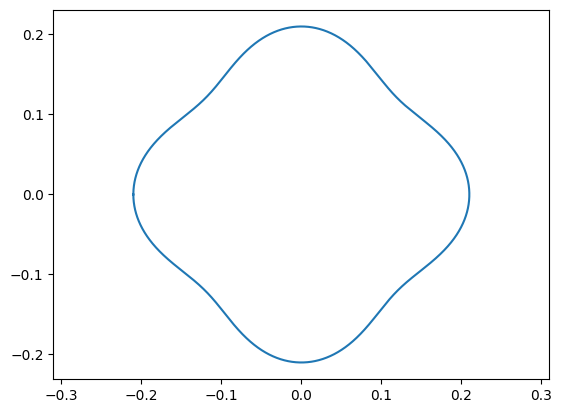

In [4]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
plt.plot(x, y)
plt.axis('equal')
# plt.show()
plt.savefig('arm_traj.png')
traj = list(zip(x,y))

### 1. Forward Model 

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
\underline{\;\;\;\;} \\
\underline{\;\;\;\;}
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

**Derivation**

Given that we have: 

- Link 0 length: $l_0 = 0.1$ m
- Link 1 length: $l_1 = 0.11$ m
- Joint angles: $q_0$ (base), $q_1$ (elbow)

We have that link 0 extends from origin at angle $q_0$:

$$\text{Elbow position: } (l_0\cos q_0, \, l_0\sin q_0)$$

And that link 1 extends from elbow at absolute angle $(q_0 + q_1)$:

$$\text{Link 1 displacement: } (l_1\cos(q_0+q_1), \, l_1\sin(q_0+q_1))$$

From here, we can calculate the End-effector position = elbow position + link 1 displacement:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
l_0\cos(q_0) + l_1\cos(q_0 + q_1) \\
l_0\sin(q_0) + l_1\sin(q_0 + q_1)
\end{bmatrix} = \begin{bmatrix} x \\ y\end{bmatrix}$$


Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [5]:
def getForwardModel(q0, q1):
    L0 = 0.1
    L1 = 0.11
    
    x = L0 * np.cos(q0) + L1 * np.cos(q0 + q1)
    y = L0 * np.sin(q0) + L1 * np.sin(q0 + q1)
    return x, y

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

**Derivation**

The Jacobian relates joint velocities to end-effector velocities, so we get:

$$\begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = J_f(q_0, q_1) \begin{bmatrix} \dot{q}_0 \\ \dot{q}_1 \end{bmatrix}$$

And from forward kinematics, we have: 

$$x = l_0\\cos(q_0) + l_1\\cos(q_0 + q_1)$$ and $$y = l_0\\sin(q_0) + l_1\\sin(q_0 + q_1)$$

We can then take partial derivatives with respect to $q_0$:

$$\frac{\partial x}{\partial q_0} = -l_0\sin(q_0) - l_1\sin(q_0 + q_1)$$
$$\frac{\partial y}{\partial q_0} = l_0\cos(q_0) + l_1\cos(q_0 + q_1)$$

And then we can take partial derivatives with respect to $q_1$:

$$\frac{\partial x}{\partial q_1} = -l_1\sin(q_0 + q_1)$$
$$\frac{\partial y}{\partial q_1} = l_1\cos(q_0 + q_1)$$

And now we can finally assemble the Jacobian matrix:
$$J_f(q_0, q_1) = \begin{bmatrix}
\frac{\partial x}{\partial q_0} & \frac{\partial x}{\partial q_1} \\
\frac{\partial y}{\partial q_0} & \frac{\partial y}{\partial q_1}
\end{bmatrix} = \begin{bmatrix}
-l_0\sin(q_0) - l_1\sin(q_0 + q_1) & -l_1\sin(q_0 + q_1) \\
l_0\cos(q_0) + l_1\cos(q_0 + q_1) & l_1\cos(q_0 + q_1)
\end{bmatrix}$$


Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [6]:
def getJacobian(q0, q1):
    L0 = 0.1
    L1 = 0.11

    J = np.array([
        [-L0 * np.sin(q0) - L1 * np.sin(q0 + q1), -L1 * np.sin(q0 + q1)],
        [ L0 * np.cos(q0) + L1 * np.cos(q0 + q1),  L1 * np.cos(q0 + q1)]])
    return J

### 3. X-Y controller

**Background:** for reasons beyond the scope of this course, it so happens that, for any robot,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot juxtaposed over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

Mean Square Error: 0.000733 m²
Gains used: Kp=50.0, Kd=10.0


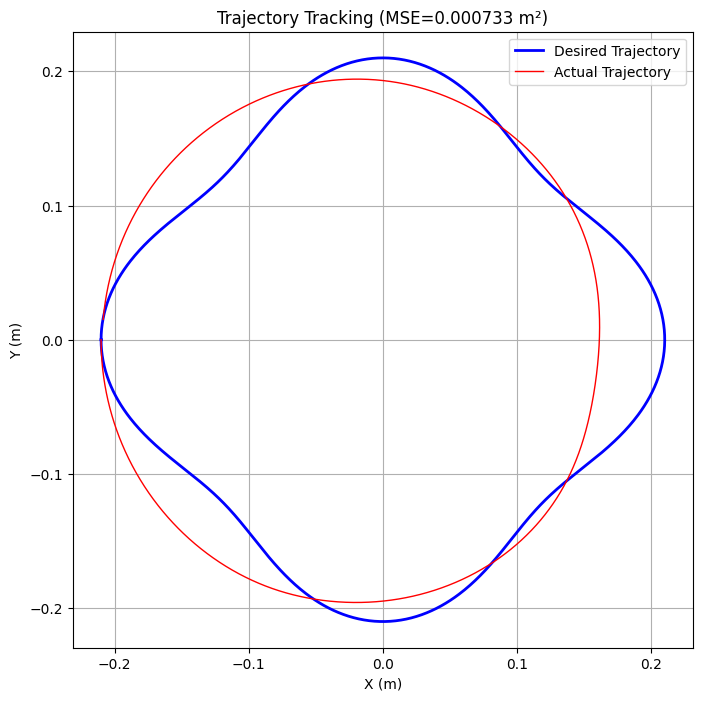

In [7]:
# Generate trajectory
theta = np.linspace(-np.pi, np.pi, 1000)
x_traj = (0.19 + 0.02 * np.cos(4 * theta)) * np.cos(theta)
y_traj = (0.19 + 0.02 * np.cos(4 * theta)) * np.sin(theta)

# PD Controller
Kp = 50.0
Kd = 10.0
dt = 0.01
total_time = 20

q0 = np.pi
q1 = 0.0
q0_dot = 0.0
q1_dot = 0.0

# Find closest point on trajectory to starting position
x_start, y_start = getForwardModel(q0, q1)
distances = np.sqrt((x_traj - x_start)**2 + (y_traj - y_start)**2)
start_idx = np.argmin(distances)

x_hist = []
y_hist = []
error_hist = []
num_steps = int(total_time / dt)

for step in range(num_steps):
    x_curr, y_curr = getForwardModel(q0, q1)
    x_hist.append(x_curr)
    y_hist.append(y_curr)
    
    traj_idx = (start_idx + int((step / num_steps) * len(x_traj))) % len(x_traj)
    x_des = x_traj[traj_idx]
    y_des = y_traj[traj_idx]
    
    e_x = x_des - x_curr
    e_y = y_des - y_curr
    error_hist.append(np.sqrt(e_x**2 + e_y**2))
    
    J = getJacobian(q0, q1)
    v_curr = J @ np.array([q0_dot, q1_dot])
    
    e_x_dot = 0 - v_curr[0]  # vref = 0
    e_y_dot = 0 - v_curr[1]
    
    F_x = Kp * e_x + Kd * e_x_dot
    F_y = Kp * e_y + Kd * e_y_dot
    F = np.array([F_x, F_y])
    
    tau = J.T @ F  # tau = J^T * F
    
    q0_dot += tau[0] * dt
    q1_dot += tau[1] * dt
    q0 += q0_dot * dt
    q1 += q1_dot * dt

# Calculate MSE
mse = np.mean(np.array(error_hist)**2)
print(f"Mean Square Error: {mse:.6f} m²")
print(f"Gains used: Kp={Kp}, Kd={Kd}")

# Plot trajectory
plt.figure(figsize=(8, 8))
plt.plot(x_traj, y_traj, 'b-', linewidth=2, label='Desired Trajectory')
plt.plot(x_hist, y_hist, 'r-', linewidth=1, label='Actual Trajectory')
plt.axis('equal')
plt.grid(True)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f'Trajectory Tracking (MSE={mse:.6f} m²)')
plt.legend()
plt.show()

**Algorithm Used to Calculate the Inverse**

1. Compute position error in task space: $e = [x_{des} - x_{curr}, y_{des} - y_{curr}]$

2. Compute velocity error: $\dot{e} = [0 - \dot{x}_{curr}, 0 - \dot{y}_{curr}]$ (since $v_{ref} = 0$)

3. Calculate desired Cartesian force using PD control: $F = K_p \cdot e + K_d \cdot \dot{e}$

4. Convert to joint torques: $\tau = J^T \cdot F$

This avoids computing $J^{-1}$ instead using the transpose $J^T$ to map Cartesian forces to joint torques based on the virtual work principle.

### 4. Inverse Kinematics

Using the functions `getForwardModel` and `getJacobian` from parts 1 and 2, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

In [8]:
def getIK(current_position, target_position, current_state):
    q0, q1 = current_state
    target_x, target_y = target_position
    
    max_iterations = 100
    tolerance = 1e-4
    alpha = 0.5 
    
    for i in range(max_iterations):
        x_curr, y_curr = getForwardModel(q0, q1)
        
        error = np.array([target_x - x_curr, target_y - y_curr])
        error_magnitude = np.linalg.norm(error)
        
        if error_magnitude < tolerance:
            break
        
        J = getJacobian(q0, q1)
        
        J_pinv = np.linalg.pinv(J)
        
        delta_q = alpha * J_pinv @ error
        
        # Update joint angles
        q0 += delta_q[0]
        q1 += delta_q[1]
    
    return np.array([q0, q1])

Now derive the analytical inverse kinematic solution; i.e. solve the problem using a closed-form equation, rather than an iterative method. _Show your work_. Correct answers without derivations will not receive full credit.

Given forward kinematics:

\begin{align*}
x &= l_0\cos(q_0) + l_1\cos(q_0 + q_1) \\
y &= l_0\sin(q_0) + l_1\sin(q_0 + q_1)
\end{align*}

We can find $q_1$ using the law of cosines:

$$r^2 = l_0^2 + l_1^2 - 2l_0l_1\cos(\pi - q_1) = l_0^2 + l_1^2 + 2l_0l_1\cos(q_1)$$

Where we have that the distance from base to target is:

$$r^2 = x^2 + y^2$$

We can now solve for $q_1$:

\begin{align*}
\cos(q_1) &= \frac{r^2 - l_0^2 - l_1^2}{2l_0l_1} \\
\cos(q_1) &= \frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1}
\end{align*}

Which gives us the following result:

$$q_1 = \pm \arccos\left(\frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1}\right)$$

We can now find $q_0$ by using geometry. We can do that by letting $\alpha = \text{atan2}(y, x)$ be the angle to the target. And letting $\beta$ be the angle from link 0 to the target. Based on this, we get the following:

\begin{align*}
\beta &= \arccos\left(\frac{l_0^2 + x^2 + y^2 - l_1^2}{2l_0\sqrt{x^2 + y^2}}\right)
\end{align*}

Then $q_0$ depends on the elbow configuration:

\begin{align*}
q_0 &= \alpha - \beta \quad \text{(elbow-up configuration)} \\
q_0 &= \alpha + \beta \quad \text{(elbow-down configuration)}
\end{align*}

Or more explicitly:

\begin{align*}
q_0 &= \text{atan2}(y, x) \pm \arccos\left(\frac{l_0^2 + x^2 + y^2 - l_1^2}{2l_0\sqrt{x^2 + y^2}}\right) \quad
\end{align*}

Therefore, the final solution becomes

\begin{aligned}
  q_0 &= \underline{\text{atan2}(y, x) \mp \arccos\left(\frac{l_0^2 + x^2 + y^2 - l_1^2}{2l_0\sqrt{x^2 + y^2}}\right)} \\
  q_1 &= \underline{\pm \arccos\left(\frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1}\right)} 
\end{aligned}


Explain what challenges there would be to use the analytical IK solution to track trajectories:

_<your explanation here\>_

One challenge with using the analytical IK solution to track trajectories is that the solution is not continuous. Since there are two possible configurations (elbow-up and elbow-down) the sign can suddenly switch while the end-effector is moving which would make the joints “jump” instead of following a smooth path.

Another issue is that the analytical expression becomes unstable near singular positions (for example when the arm is fully stretched). Small changes in the end-effector position can create very large changes in the joint angles.

Finally, the target might leave the reachable workspace during a fast trajectory because the analytical IK has no valid solution at all. In contrast, a numerical method can still move in the right direction even if the point is not exactly reachable.

### 5. IK controller

Implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot juxtaposed over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

Mean Square Error (Joint-space PD): 0.000157
Gains used: Kp=50.0, Kd=10.0


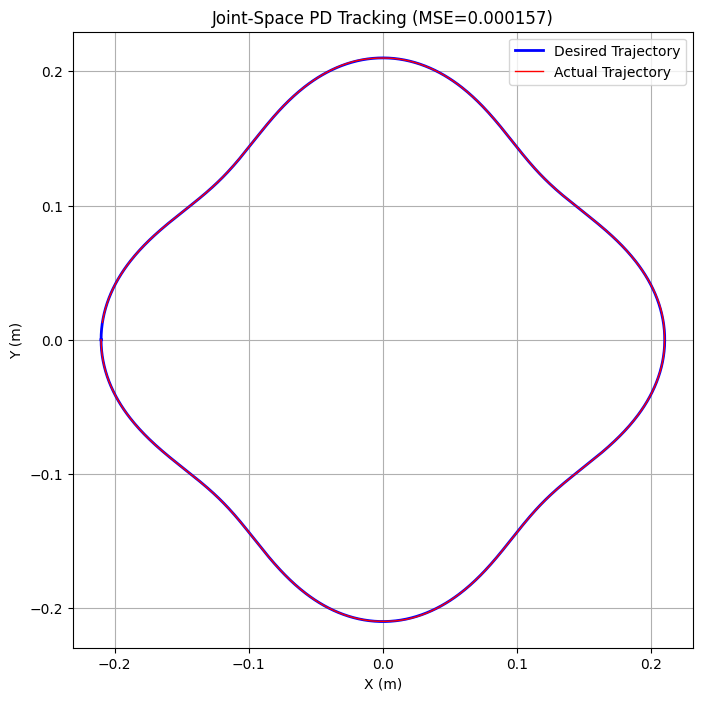

In [ ]:
# Write your script here.

Kp = 50.0   
Kd = 10.0    
dt = 0.01
total_time = 20

# Initial joint
q0 = np.pi
q1 = 0.0
q0_dot = 0.0
q1_dot = 0.0

desired_q = []
q0_temp = np.pi
q1_temp = 0.0
for x_d, y_d in zip(x_traj, y_traj):
    q_sol = getIK(getForwardModel(q0_temp, q1_temp), (x_d, y_d), (q0_temp, q1_temp))
    desired_q.append(q_sol)
    q0_temp, q1_temp = q_sol

desired_q = np.array(desired_q)

q0 = np.pi
q1 = 0.0
q0_dot = 0.0
q1_dot = 0.0

q0_des_hist = []
q1_des_hist = []
x_hist = []
y_hist = []
error_hist = []

num_steps = int(total_time / dt)

for step in range(num_steps):
    x_curr, y_curr = getForwardModel(q0, q1)
    x_hist.append(x_curr)
    y_hist.append(y_curr)

    progress = (step / num_steps) * len(desired_q)
    idx = int(progress) % len(desired_q)
    q0_des = desired_q[idx, 0]
    q1_des = desired_q[idx, 1]

    q0_des_hist.append(q0_des)
    q1_des_hist.append(q1_des)

    e_q0 = q0_des - q0
    e_q1 = q1_des - q1
    
    x_des = x_traj[idx]
    y_des = y_traj[idx]
    error_hist.append(np.sqrt((x_des - x_curr)**2 + (y_des - y_curr)**2))

    e_q0_dot = 0 - q0_dot
    e_q1_dot = 0 - q1_dot

    tau0 = Kp * e_q0 + Kd * e_q0_dot
    tau1 = Kp * e_q1 + Kd * e_q1_dot

    q0_dot += tau0 * dt
    q1_dot += tau1 * dt
    q0 += q0_dot * dt
    q1 += q1_dot * dt

mse = np.mean((np.array(error_hist))**2)
print(f"Mean Square Error (Joint-space PD): {mse:.6f}")
print(f"Gains used: Kp={Kp}, Kd={Kd}")

# Plotting
plt.figure(figsize=(8,8))
plt.plot(x_traj, y_traj, 'b-', linewidth=2, label='Desired Trajectory')
plt.plot(x_hist, y_hist, 'r-', linewidth=1, label='Actual Trajectory')
plt.axis('equal')
plt.grid(True)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f'Joint-Space PD Tracking (MSE={mse:.6f})')
plt.legend()
plt.show()